# Vowel Overlap Analysis
We'd like to investigate whether model substitution errors for vowel are related to the overlap between vowels according to the Pillai scores. We'll run correlations comparing the substitution rate between an original vowel _v_ and a substitution _w_ with the Pillai score of _v,w_. 
We'll do this analysis for a single AutoIPA model, but in two settings: 
- Within Buckeye: Comparing substitution rates on the Buckeye test set to Pillai scores computed on the Buckeye corpus
- On TIMIT: Comparing substitution rates on the TIMIT corpus to Pillai scores that compare TIMIT vowels to Buckeye vowels


In [ ]:
from collections import Counter, defaultdict
from pathlib import Path
from typing import Iterable

import ipatok
import kaldialign
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.color_palette("colorblind")
font = {"size": 16}
matplotlib.rc("font", **font)
# Remove the limits on the number of rows displayed in the notebook
pd.options.display.max_rows = None


In [2]:
TIMIT_VOWELS = ["ɑ", "æ", "ʌ", "ɔ", "ɛ", "ɪ", "i", "ʊ", "u", "ə", "ə̥", "ʉ", "ɨ", "ɹ̩"]
TIMIT_DIPHTHONGS = ["aʊ", "eɪ", "aɪ", "oʊ", "ɔɪ"]

# This doesn't include all the nasalized vowels, only the ones that we computed the Pillai scores for
BUCKEYE_VOWELS = ["æ", "æ̃", "i", "u", "ĩ", "ɑ", "ɔ", "ɛ", "ɪ", "ʊ", "ʌ", "ɑ̃", "ɛ̃","ɪ̃", "ɹ̩", "ʌ̃", "ũ"]
# Includes all diphthongs, including nasalized, just to make tokenization and counts consistent
BUCKEYE_DIPHTHONGS = ["eɪ", "oʊ", "aʊ", "aɪ", "ɔɪ", "ẽɪ̃", "õʊ̃", "ãɪ̃", "ãʊ̃", "ɔ̃ɪ̃"]

BUCKEYE_TRANSCRIPTIONS = Path(
    "../../data/evaluation_results/detailed_predictions/ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv"
)
WITHIN_BUCKEYE_PILLAI_CSV = Path("./pillai_scores_within_buckeye.csv")


TIMIT_GOLD_TRANSCRIPTIONS = Path("../../data/TIMIT Dataset/complete_ipa.csv")
TIMIT_MODEL_PREDICTIONS = Path(
    "../../data/timit_results/detailed_predictions/ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv"
)
TIMIT_VS_BUCKEYE_PILLAI = Path("./pillai_scores_buckeye_timit.csv")

In [3]:
# Sets up reusable functions for tokenization and substitution calculations

EPS = "***"

def tally_edit_distance_errors(references, predictions):
    """Counts up edit distances from lists of already tokenized references and predictions."""
    subs = Counter()
    insertions = Counter()
    deletions = Counter()
    for ref_tokens, pred_tokens in zip(references, predictions):
        aligned_pairs = kaldialign.align(ref_tokens, pred_tokens, EPS)

        for r, p in aligned_pairs:
            if r == EPS:
                insertions[p] += 1
            elif p == EPS:
                deletions[r] += 1
            elif r != p:
                subs[(r, p)] += 1

    return subs, deletions, insertions


def diphthong_merge(t1, t2, dipthongs):
    """For merge detected diphthongs in predicted output when using ipatok.tokenise"""
    if t1 + t2 in dipthongs:
        return True
    else:
        return False

# Use for Buckeye tokenization for convenience
buckeye_merge_func = lambda x,y: diphthong_merge(x, y, BUCKEYE_DIPHTHONGS)

# Use for TIMIT tokenization for convenience
timit_merge_func = lambda x, y: diphthong_merge(x, y, TIMIT_DIPHTHONGS)


def get_substitution_counts_as_dataframe(substitutions: Counter[tuple]):
    """Converts the substition counter to a DataFrame"""
    return pd.DataFrame([(t[0], t[1], count) for t, count in substitutions.items()], columns=["original", "substitution", "substitution_count"])

def get_total_token_counts(token_lists:Iterable[list[str]]):
    """Count up tokens and return the results as a dataframe"""
    token_counter = Counter()
    for tokens in token_lists:
        token_counter.update(tokens)
    return token_counter, pd.DataFrame(token_counter.items(), columns=["phone", "total_count"])


def get_normalized_substitution_counts_df(substitutions_df, token_counts_df,
                                  substitution_join_key = "original",substitution_count_key="substitution_count", total_counts_join_key="phone", total_counts_count_key="total_count"):
    """Given a DataFrame of phone substitutions and a DataFrame of phone counts, join them and compute normalized substitution
    error rates.
    Returns the joined dataframe with a "normalized_substitution_rate".
    """
    joined_df = pd.merge(substitutions_df, token_counts_df, left_on=substitution_join_key, right_on=total_counts_join_key)
    joined_df["normalized_substitution_rate"] = joined_df[substitution_count_key] / joined_df[total_counts_count_key]
    return joined_df

def get_error_rates_with_deletions(subs_counter, del_counter, overall_counts, desired_tokens):
    err_rate = {}
    for token in desired_tokens:
        if token in overall_counts:
            subs_count = subs_counter[token]
            dels_count = del_counter[token]
            ver = (subs_count + dels_count) / (overall_counts[token])
            print(token, "Subs:", subs_count, "Dels:", dels_count, "Total:", overall_counts[token])
            err_rate[token] = ver
        else:
            print(f"Warning: '{token}' not in Buckeye test corpus gold standard transcriptions")

    return err_rate

def compute_error_rate_confidence_intervals_df(error_rate_df, count_df, error_rate_join_key, count_join_key, error_rate_col, count_col, interval_const = 1.96):
    """Computes error rates for each vowel with a confidence interval of according to
    https://machinelearningmastery.com/report-classifier-performance-confidence-intervals/
    The default settings give a confidence interval of 95%.
    """
    joined_df = pd.merge(error_rate_df, count_df, left_on=error_rate_join_key, right_on=count_join_key, how="inner")
    error_series = joined_df[error_rate_col]
    joined_df["confidence_interval"] = interval_const * np.sqrt( (error_series *(1-error_series))/ joined_df[count_col])
    return joined_df


def plot_error_rate_heat_map(err_rate_df, title, key="Vowel Error Rate", index="Vowel", cmap_palette="rainbow", vmin=0, vmax=None, annot=True, fmt = ".2f") -> None:
    """Plots error rates/frequency for vowels (or whatever desired token) as a heatmap"""
    plot_df = err_rate_df.sort_values(by=key, ascending=False).set_index(index)
    plt.figure(figsize=(4, 6))
    sns.heatmap(
        plot_df,
        cmap=cmap_palette,
        # cmap="spring_r",
        annot=annot,
        fmt=fmt,
        # linewidths=1,
        vmin=vmin, vmax=vmax, # Alow tweaking lower and upper bounds
        yticklabels=plot_df.index # label everything
    )
    plt.title(title, y=1.05)
    plt.yticks(rotation=0)
    plt.ylabel("")
    plt.show()

def join_substitutions_errors_and_pillai_scores(substitutions_df, pillai_df,
                                                    pillai_vowel1_key, pillai_vowel2_key,
                                                    substitutions_orig_key = "original", substitutions_sub_key = "substitution"):
    # First match: original=vowel1 AND substitution=vowel2
    result1 = pd.merge(
        substitutions_df,
        pillai_df,
        left_on=[substitutions_orig_key, substitutions_sub_key],
        right_on=[pillai_vowel1_key, pillai_vowel2_key],
        how="inner"  # Only get matches for this condition
    )

    # Second match: original=vowel2 AND substitution=vowel2
    result2 = pd.merge(
        substitutions_df,
        pillai_df,
        left_on=[substitutions_orig_key, substitutions_sub_key],
        right_on=[pillai_vowel2_key, pillai_vowel1_key],
        how="inner",  # Only get matches for this condition
    )

    # Combine successful matches from both conditions
    matched_results = pd.concat([result1, result2]).drop_duplicates()
    return matched_results

def plot_pillai_substitution_rate_relationship_scatter(joined_df, plot_title, pearsons_position,  pillai_col="Pillai", nsr_col="normalized_substitution_rate", xlim=None, ylim=None, equality_hue_col=None ):
    pearson_r = scipy.stats.pearsonr(
            joined_df["Pillai"], joined_df[nsr_col]
        )
    print(pearson_r)
    g = sns.scatterplot(data=joined_df, x=nsr_col, y=pillai_col, hue=equality_hue_col)
    plt.xlabel("Normalized rate of $\it{v}$ substituted by $\it{w}$")
    plt.ylabel("Pillai score of $\it{v, w}$")
    g.annotate("Pearson r: {:.2f}".format(pearson_r[0]), xy=pearsons_position)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if equality_hue_col is not None:
        plt.legend(title="Does $\it{v}$ equal $\it{w}$?", bbox_to_anchor=(1.02, 0.8), loc="upper left")
    plt.title(plot_title, y=1.05)


def plot_pillai_substitution_rate_relationship_heatmap(joined_df, plot_title, pillai_col="Pillai", nsr_col="normalized_substitution_rate", nsr_label = "Normalized Substitution Rate", xlabel="substituted vowel", ylabel="original vowel", mask_above_diagonal=True):
    combined_long = pd.melt(
            joined_df,
            id_vars=["original", "substitution"],
            value_vars=[nsr_col, pillai_col],
            var_name="measure",
            value_name="value",
        )


    # Make measure names nicer
    measure_names = {nsr_col: nsr_label, pillai_col: "Pillai"}
    combined_long["measure"] = combined_long["measure"].map(measure_names)


    # Custom plotting function for the heatmaps
    def plot_heatmap(data, **kwargs):
        # Create a pivot table for just this facet's data
        pivot_data = data.pivot(index="original", columns="substitution", values="value")

        # Create the mask for upper triangular region
        mask=None
        if mask_above_diagonal:
            mask = np.triu(np.ones_like(pivot_data, dtype=bool))

        ax = sns.heatmap(pivot_data, mask=mask, vmin=0, vmax=1, yticklabels=True, cbar=False, **kwargs)
        ax.set(xlabel=xlabel, ylabel=ylabel)

    # Create the FacetGrid
    cmap="rainbow"
    fig = plt.figure(figsize=(16, 7))
    g = sns.FacetGrid(combined_long, col="measure", height=6, aspect=1)
    g.axes.flat[-1]
    g.map_dataframe(plot_heatmap, cmap=cmap)

    # Add colorbar on right side
    cax = g.figure.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])  # Required for the mappable to work with colorbar
    cbar = fig.colorbar(sm, cax=cax)
    cbar.outline.set_visible(False)

    g.set_titles(col_template="{col_name}")
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    g.figure.suptitle(plot_title, y=1.05)
    plt.show()

## Within Buckeye Comparison

In [4]:
# Read in data, tokenize phones and get edit distance errors
buckeye_results_df = pd.read_csv(BUCKEYE_TRANSCRIPTIONS)

for (in_col, out_col) in [("ipa", "ipa_tokens"), ("prediction", "prediction_tokens")]:
    buckeye_results_df[out_col] = buckeye_results_df[in_col].apply(lambda x: ipatok.tokenise(str(x), diphthongs=True, merge=buckeye_merge_func))

buckeye_results_df.head()

,utterance_id,duration,buckeye_transcript,text,ipa,speaker_id,speaker_gender,speaker_age_range,interviewer_gender,file_path,prediction,phone_error_rates,phone_feature_error_rates,feature_error_rates,deletions,insertions,substitutions,ipa_tokens,prediction_tokens
0,s2501a_Utt0,0.925981,f ao r f ay v,four five,fɔɹfaɪv,S25,f,o,m,data/buckeye/test/s2501a_Utt0.wav,fɔɹɹ̩faɪv,0.142857,1.000000,0.264881,{},{'ɹ̩': 1},{},"[f, ɔ, ɹ, f, aɪ, v]","[f, ɔ, ɹ, ɹ̩, f, aɪ, v]"
1,s2501a_Utt1,13.394466,U uw ah nx ay hh ey tq hh iy r ih n m ay s eh ...,EXCLUDE-four_five_six_seven_eight_nine_ten_ele...,uʌɾ̃aɪheɪʔhiɹɪnmaɪsɛlfɑn,S25,f,o,m,data/buckeye/test/s2501a_Utt1.wav,uɛɾ̃aɪheɪʔhiɹɪnmaɪsɛlfɑnt,0.086957,1.083333,0.003623,{},{'t': 1},"{('ʌ', 'ɛ'): 1}","[u, ʌ, ɾ̃, aɪ, h, eɪ, ʔ, h, i, ɹ, ɪ, n, m, aɪ,...","[u, ɛ, ɾ̃, aɪ, h, eɪ, ʔ, h, i, ɹ, ɪ, n, m, aɪ,..."
2,s2501a_Utt2,22.609051,ah k ey U ah m ay tq w aa n n ah ch r ay dx uh...,okay VOCNOISE i might want to try to adjust th...,ʌkeɪʌmaɪʔwɑnnʌtʃɹaɪɾʊɪdʒʌssɪsʌlɪɾl̩bɪɾɪɡɛnɪfjʌ...,S25,f,o,m,data/buckeye/test/s2501a_Utt2.wav,aɪkeɪmaɪʔwɑnʌtʃɹaɪdʌdʒɛsɪsʌɾisɪɡoʊzʌnɹ̩ɹæiʌste...,0.605263,28.875000,0.169956,"{'ʌ': 2, 'n': 3, 'ɪ': 6, 's': 1, 'l': 2, 'b': ...","{'ɪ': 1, 'ʊ': 1}","{('ʌ', 'a'): 1, ('ɾ', 'd'): 1, ('ʊ', 'ʌ'): 1, ...","[ʌ, k, eɪ, ʌ, m, aɪ, ʔ, w, ɑ, n, n, ʌ, t, ʃ, ɹ...","[aɪ, k, eɪ, m, aɪ, ʔ, w, ɑ, n, ʌ, t, ʃ, ɹ, aɪ,..."
3,s2501a_Utt3,2.279839,n aa t U ih tq ah z b eh dx er b ih f ao r,not LAUGH it was better before,nɑtɪʔʌzbɛɾɹ̩bɪfɔɹ,S25,f,o,m,data/buckeye/test/s2501a_Utt3.wav,nɑʔɪʔʌzbɛɾɹ̩bɪfɔɹ,0.062500,0.250000,0.014323,{},{},"{('t', 'ʔ'): 1}","[n, ɑ, t, ɪ, ʔ, ʌ, z, b, ɛ, ɾ, ɹ̩, b, ɪ, f, ɔ, ɹ]","[n, ɑ, ʔ, ɪ, ʔ, ʌ, z, b, ɛ, ɾ, ɹ̩, b, ɪ, f, ɔ, ɹ]"
4,s2501a_Utt4,0.410576,dh eh r,there,ðɛɹ,S25,f,o,m,data/buckeye/test/s2501a_Utt4.wav,ðɛɹ,0.000000,0.000000,0.000000,{},{},{},"[ð, ɛ, ɹ]","[ð, ɛ, ɹ]"


In [5]:
buckeye_subs, buckeye_dels, _ = tally_edit_distance_errors(buckeye_results_df["ipa_tokens"], buckeye_results_df["prediction_tokens"])
buckeye_subs_df = get_substitution_counts_as_dataframe(buckeye_subs)

buckeye_dels_df = pd.DataFrame(list(buckeye_dels.items()), columns=["deleted", "count"])

# Filter to just vowels
buckeye_subs_df = buckeye_subs_df[buckeye_subs_df["original"].isin(BUCKEYE_VOWELS + BUCKEYE_DIPHTHONGS)]
buckeye_dels_df = buckeye_dels_df[buckeye_dels_df["deleted"].isin(BUCKEYE_VOWELS + BUCKEYE_DIPHTHONGS)]
display(buckeye_subs_df.head())
display(buckeye_dels_df.head())


,original,substitution,substitution_count
0,ʌ,ɛ,474
1,ʌ,aɪ,93
3,ʊ,ʌ,199
5,u,oʊ,5
7,aɪ,æ,31


,deleted,count
0,ʌ,1033
2,ɪ,860
8,ɛ,307
11,eɪ,89
19,aɪ,143


In [6]:
buckeye_overall_substitutions_df = buckeye_subs_df.groupby("original")["substitution_count"].sum().reset_index()
buckeye_overall_sub_counts = defaultdict(int)
buckeye_overall_sub_counts.update(buckeye_overall_substitutions_df.set_index("original").to_dict()["substitution_count"])
print(buckeye_overall_sub_counts)
display(buckeye_overall_substitutions_df)

defaultdict(<class 'int'>, {'aɪ': 599, 'aʊ': 228, 'eɪ': 382, 'i': 878, 'oʊ': 885, 'u': 403, 'æ': 612, 'æ̃': 48, 'ɑ': 470, 'ɑ̃': 28, 'ɔ': 455, 'ɔɪ': 28, 'ɔ̃ɪ̃': 9, 'ɛ': 1711, 'ɛ̃': 61, 'ɪ': 3678, 'ɪ̃': 84, 'ɹ̩': 375, 'ʊ': 454, 'ʌ': 3326, 'ʌ̃': 78})


,original,substitution_count
0,aɪ,599
1,aʊ,228
2,eɪ,382
3,i,878
4,oʊ,885
5,u,403
6,æ,612
7,æ̃,48
8,ɑ,470
9,ɑ̃,28


In [7]:
buckeye_token_counts, buckeye_token_counts_df = get_total_token_counts(buckeye_results_df["ipa_tokens"])
display(buckeye_token_counts_df.head())

,phone,total_count
0,f,2348
1,ɔ,1720
2,ɹ,6185
3,aɪ,4201
4,v,2329


In [8]:
# Compute and plot error rates considering both substitutions and deletions
buckeye_vowel_error_rates = get_error_rates_with_deletions(
    buckeye_overall_sub_counts, buckeye_dels, buckeye_token_counts, BUCKEYE_VOWELS + BUCKEYE_DIPHTHONGS
)
buckeye_ver_df = pd.DataFrame(buckeye_vowel_error_rates.items(), columns=["Vowel", "Vowel Error Rate"]).sort_values("Vowel Error Rate", ascending=False)
display(buckeye_ver_df)


æ Subs: 612 Dels: 131 Total: 3302
æ̃ Subs: 48 Dels: 2 Total: 67
i Subs: 878 Dels: 264 Total: 6631
u Subs: 403 Dels: 125 Total: 2325
ɑ Subs: 470 Dels: 74 Total: 2737
ɔ Subs: 455 Dels: 63 Total: 1720
ɛ Subs: 1711 Dels: 307 Total: 6829
ɪ Subs: 3678 Dels: 860 Total: 12433
ʊ Subs: 454 Dels: 85 Total: 1085
ʌ Subs: 3326 Dels: 1033 Total: 14477
ɑ̃ Subs: 28 Dels: 0 Total: 28
ɛ̃ Subs: 61 Dels: 8 Total: 72
ɪ̃ Subs: 84 Dels: 17 Total: 102
ɹ̩ Subs: 375 Dels: 86 Total: 3088
ʌ̃ Subs: 78 Dels: 11 Total: 89
eɪ Subs: 382 Dels: 89 Total: 3035
oʊ Subs: 885 Dels: 183 Total: 3788
aʊ Subs: 228 Dels: 29 Total: 975
aɪ Subs: 599 Dels: 143 Total: 4201
ɔɪ Subs: 28 Dels: 3 Total: 105
ɔ̃ɪ̃ Subs: 9 Dels: 0 Total: 9


,Vowel,Vowel Error Rate
10,ɑ̃,1.000000
14,ʌ̃,1.000000
20,ɔ̃ɪ̃,1.000000
12,ɪ̃,0.990196
11,ɛ̃,0.958333
1,æ̃,0.746269
8,ʊ,0.496774
7,ɪ,0.364996
5,ɔ,0.301163
9,ʌ,0.301098


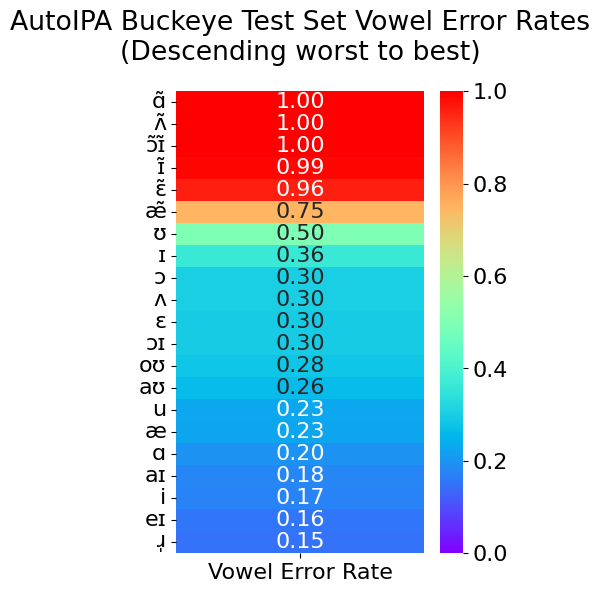

In [9]:
plot_error_rate_heat_map(buckeye_ver_df, "AutoIPA Buckeye Test Set Vowel Error Rates\n(Descending worst to best)")

In [10]:

# Confidence intervals for error rate
buckeye_full_err_rate_analysis= compute_error_rate_confidence_intervals_df(buckeye_ver_df, buckeye_token_counts_df, "Vowel", "phone", "Vowel Error Rate", "total_count").sort_values("Vowel Error Rate", ascending=False)
display(buckeye_full_err_rate_analysis)



,Vowel,Vowel Error Rate,phone,total_count,confidence_interval
0,ɑ̃,1.000000,ɑ̃,28,0.000000
1,ʌ̃,1.000000,ʌ̃,89,0.000000
2,ɔ̃ɪ̃,1.000000,ɔ̃ɪ̃,9,0.000000
3,ɪ̃,0.990196,ɪ̃,102,0.019121
4,ɛ̃,0.958333,ɛ̃,72,0.046158
5,æ̃,0.746269,æ̃,67,0.104197
6,ʊ,0.496774,ʊ,1085,0.029751
7,ɪ,0.364996,ɪ,12433,0.008463
8,ɔ,0.301163,ɔ,1720,0.021681
9,ʌ,0.301098,ʌ,14477,0.007473


In [11]:
# Normalize substitution counts by overall phone occurrence counts
buckeye_normalized_substitution_rates = get_normalized_substitution_counts_df(buckeye_subs_df, buckeye_token_counts_df).sort_values(by=["original", "normalized_substitution_rate"], ascending=[True, False])
display(buckeye_normalized_substitution_rates.head())

,original,substitution,substitution_count,phone,total_count,normalized_substitution_rate
111,aɪ,ɑ,225,aɪ,4201,0.053559
109,aɪ,ʌ,179,aɪ,4201,0.042609
112,aɪ,ɛ,67,aɪ,4201,0.015949
106,aɪ,æ,31,aɪ,4201,0.007379
114,aɪ,eɪ,22,aɪ,4201,0.005237


In [12]:
# Read and join in Pillai scores with substitutions
buckeye_pillai_df = pd.read_csv(WITHIN_BUCKEYE_PILLAI_CSV)
buckeye_pillai_df.head()

buckeye_subs_pillai_df = join_substitutions_errors_and_pillai_scores(
    buckeye_normalized_substitution_rates, buckeye_pillai_df, "Vowel1", "Vowel2"
)
buckeye_subs_pillai_df.to_csv("buckeye_pillai_vs_sub_rate.csv", index=False)
display(buckeye_subs_pillai_df.head(20))


,original,substitution,substitution_count,phone,total_count,normalized_substitution_rate,Vowel1,Vowel2,Df,Pillai,approx F,num Df,den Df,Pr(>F),Vowel1_Count,Vowel2_Count,Total_Count
0,eɪ,ɪ,69,eɪ,3035,0.022735,eɪ,ɪ,1,0.047209,1139.875312,2,46011,0.000000e+00,10313,35701,46014
1,eɪ,æ,20,eɪ,3035,0.006590,eɪ,æ,1,0.432168,6750.820056,2,17740,0.000000e+00,10313,7430,17743
2,eɪ,u,2,eɪ,3035,0.000659,eɪ,u,1,0.164685,1722.824409,2,17477,0.000000e+00,10313,7167,17480
3,eɪ,ɑ,1,eɪ,3035,0.000329,eɪ,ɑ,1,0.756085,28600.176567,2,18453,0.000000e+00,10313,8143,18456
4,eɪ,æ̃,1,eɪ,3035,0.000329,eɪ,æ̃,1,0.009435,50.574325,2,10619,1.379740e-22,10313,309,10622
5,eɪ,ʊ,1,eɪ,3035,0.000329,eɪ,ʊ,1,0.297374,2832.059464,2,13383,0.000000e+00,10313,3073,13386
6,eɪ,ɛ̃,1,eɪ,3035,0.000329,eɪ,ɛ̃,1,0.038408,211.352619,2,10583,9.918551e-91,10313,273,10586
7,eɪ,ɔ,1,eɪ,3035,0.000329,eɪ,ɔ,1,0.648165,15718.030740,2,17064,0.000000e+00,10313,6754,17067
8,i,ɪ,569,i,6631,0.085809,i,ɪ,1,0.198953,7483.758716,2,60264,0.000000e+00,24566,35701,60267
9,i,eɪ,66,i,6631,0.009953,i,eɪ,1,0.094617,1822.351288,2,34876,0.000000e+00,24566,10313,34879


PearsonRResult(statistic=-0.28955972362130505, pvalue=0.00015438119460526426)


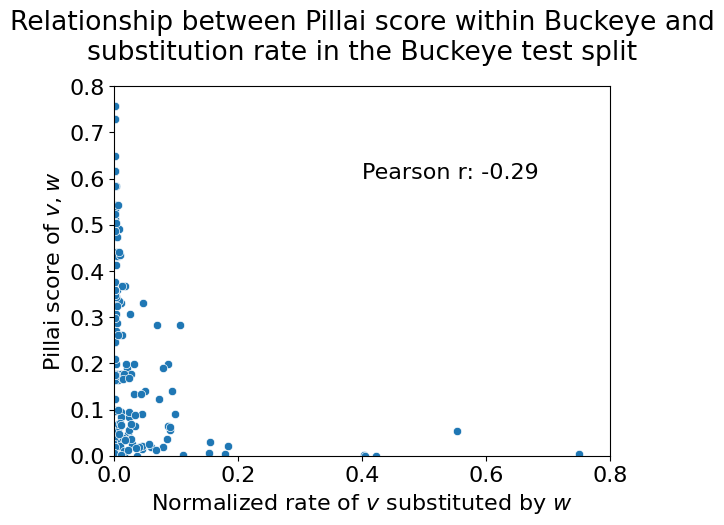

In [13]:
plot_pillai_substitution_rate_relationship_scatter(buckeye_subs_pillai_df, "Relationship between Pillai score within Buckeye and\nsubstitution rate in the Buckeye test split", pearsons_position=(0.4, 0.6), xlim=(0, 0.8), ylim=(0,0.8))

/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_52103/2081499157.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


<Figure size 1600x700 with 0 Axes>

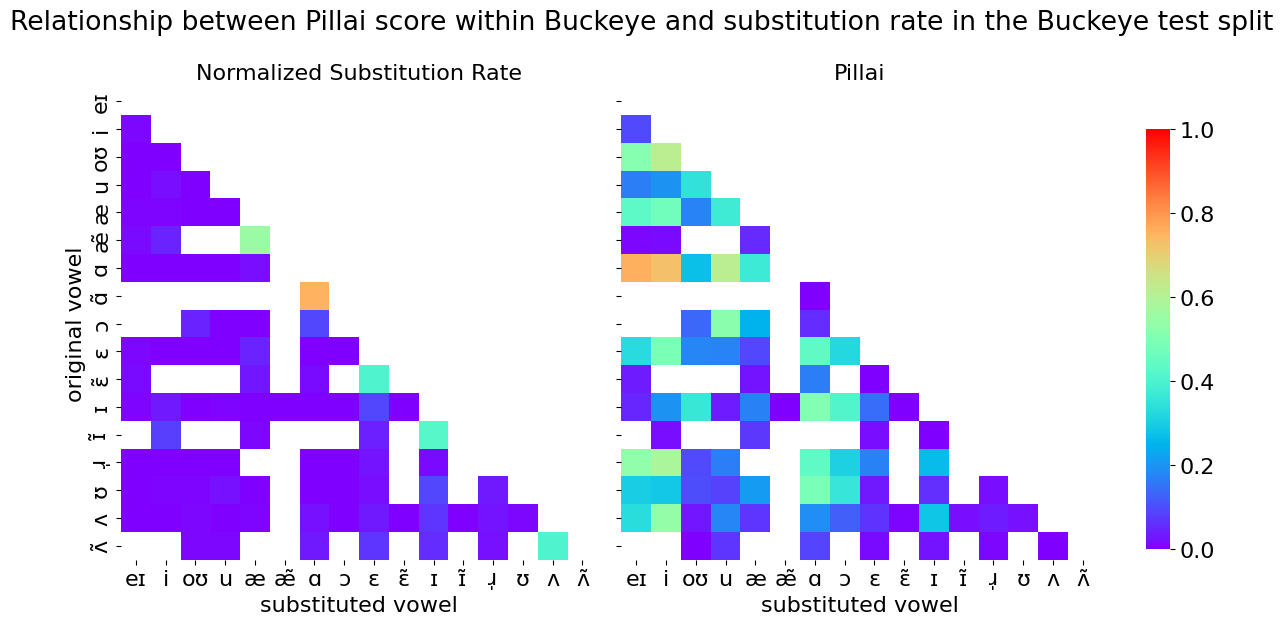

In [14]:
plot_pillai_substitution_rate_relationship_heatmap(buckeye_subs_pillai_df, "Relationship between Pillai score within Buckeye and substitution rate in the Buckeye test split")

# TIMIT vs Buckeye
Now we do more or less the same thing, but with TIMIT data for edit distance errors. 

In [15]:
# Read in the TIMIT data and get edit distance errors
timit_results_df = pd.read_csv(TIMIT_MODEL_PREDICTIONS)
timit_gold_df = pd.read_csv(TIMIT_GOLD_TRANSCRIPTIONS)
timit_gold_df["filename"] = timit_gold_df["audio_filename"].str.lower()
timit_results_df = pd.merge(left=timit_results_df, right=timit_gold_df, on="filename")

timit_results_df["ipa_transcription"] = timit_results_df["ipa_transcription"].str.replace("ɝ", "ɹ̩")

# Tokenise
timit_results_df["ipa_tokens"] = timit_results_df["ipa_transcription"].str.split()
timit_results_df["prediction_tokens"] = timit_results_df["prediction"].apply(lambda x: ipatok.tokenise(str(x), diphthongs=True, merge=timit_merge_func))

display(timit_results_df.head())

,filename,ipa,prediction,phone_error_rates,phone_feature_error_rates,feature_error_rates,deletions,insertions,substitutions,audio_filename,ipa_transcription,ipa_tokens,prediction_tokens
0,/complete/dr6/meal0/si2177.wav,ʃuwəzhoʊlɾɨŋʔɑɾ̃ʊɦɪzɹɑkwəðwʌnɦænd,ʃiwʊzhoʊlɾɪŋɑndʌhɪzɹɑkwʊðwʌnhænd,0.312500,1.708333,0.185547,{'ʔ': 1},{'h': 1},"{('u', 'i'): 1, ('ə', 'ʊ'): 2, ('ɨ', 'ɪ'): 1, ...",/COMPLETE/DR6/MEAL0/SI2177.wav,ʃ u w ə z h oʊ l ɾ ɨ ŋ ʔ ɑ ɾ̃ ʊ ɦ ɪ z ɹ ɑ k w...,"[ʃ, u, w, ə, z, h, oʊ, l, ɾ, ɨ, ŋ, ʔ, ɑ, ɾ̃, ʊ...","[ʃ, i, w, ʊ, z, h, oʊ, l, ɾ, ɪ, ŋ, ɑ, n, d, ʌ,..."
1,/complete/dr6/meal0/sx197.wav,dɹɔʔitʃgɹæfʌɾ̃eɪnuæksɨs,dʒɹɔitʃɡɹæfɑneɪnuæksɛs,0.285714,2.291667,0.241071,{'ʔ': 1},{'ʒ': 1},"{('g', 'ɡ'): 1, ('ʌ', 'ɑ'): 1, ('ɾ̃', 'n'): 1,...",/COMPLETE/DR6/MEAL0/SX197.wav,d ɹ ɔ ʔ i tʃ g ɹ æ f ʌ ɾ̃ eɪ n u æ k s ɨ s,"[d, ɹ, ɔ, ʔ, i, tʃ, g, ɹ, æ, f, ʌ, ɾ̃, eɪ, n, ...","[d, ʒ, ɹ, ɔ, i, t, ʃ, ɡ, ɹ, æ, f, ɑ, n, eɪ, n,..."
2,/complete/dr6/meal0/sa1.wav,ʃɨɦædʒɹ̩dɑɹksʉtʔɨŋgɹisɨwɔʃwɔɾɚʔɔljɨɚ,ʃɪhæddʒɹ̩dɑɹksuʔɪŋɡɹisiwɔʃwɔɾɹ̩ɔljɪɹ,0.343750,3.625000,0.259766,"{'t': 1, 'ʔ': 1}",{'d': 1},"{('ɨ', 'ɪ'): 3, ('ɦ', 'h'): 1, ('ʉ', 'u'): 1, ...",/COMPLETE/DR6/MEAL0/SA1.wav,ʃ ɨ ɦ æ dʒ ɹ̩ d ɑ ɹ k s ʉ t ʔ ɨ ŋ g ɹ i s ɨ w...,"[ʃ, ɨ, ɦ, æ, dʒ, ɹ̩, d, ɑ, ɹ, k, s, ʉ, t, ʔ, ɨ...","[ʃ, ɪ, h, æ, d, d, ʒ, ɹ̩, d, ɑ, ɹ, k, s, u, ʔ,..."
3,/complete/dr6/meal0/sx287.wav,n̩ʌlɔŋɹʌnɨtpeɪztɨbaɪkwɔləɾɨkloʊðɨŋ,n̩ʌlɔŋɹʌnʌpeɪstʌbaɪkwɑlʌɾikloʊðɪŋ,0.242424,1.458333,0.175505,{'t': 1},{},"{('ɨ', 'ʌ'): 2, ('z', 's'): 1, ('ɔ', 'ɑ'): 1, ...",/COMPLETE/DR6/MEAL0/SX287.wav,n̩ ʌ l ɔ ŋ ɹ ʌ n ɨ t p eɪ z t ɨ b aɪ k w ɔ l ...,"[n̩, ʌ, l, ɔ, ŋ, ɹ, ʌ, n, ɨ, t, p, eɪ, z, t, ɨ...","[n̩, ʌ, l, ɔ, ŋ, ɹ, ʌ, n, ʌ, p, eɪ, s, t, ʌ, b..."
4,/complete/dr6/meal0/sx347.wav,ðɨpeɪʃɨntʔɛnðəsɹ̩dʒɨɾ̃ɚboʊθɚkupɹɛɾɨŋfɚmðɨlɛŋθi...,ðipeɪʃɪntɛnʌsɹ̩dʒʌnɹ̩boʊlθfɪkupɹeɪɾɪŋfʌmðilɛŋk...,0.395833,10.125000,0.365885,"{'ʔ': 1, 'ə': 1}","{'l': 1, 'ɪ': 2, 'k': 1, 'n': 1}","{('ɨ', 'i'): 2, ('ɨ', 'ɪ'): 2, ('ð', 'ʌ'): 1, ...",/COMPLETE/DR6/MEAL0/SX347.wav,ð ɨ p eɪ ʃ ɨ n t ʔ ɛ n ð ə s ɹ̩ dʒ ɨ ɾ̃ ɚ b o...,"[ð, ɨ, p, eɪ, ʃ, ɨ, n, t, ʔ, ɛ, n, ð, ə, s, ɹ̩...","[ð, i, p, eɪ, ʃ, ɪ, n, t, ɛ, n, ʌ, s, ɹ̩, d, ʒ..."


In [16]:
timit_subs, timit_dels, _ = tally_edit_distance_errors(
    timit_results_df["ipa_tokens"], timit_results_df["prediction_tokens"]
)
timit_subs_df = get_substitution_counts_as_dataframe(timit_subs)

timit_dels_df = pd.DataFrame(list(timit_dels.items()), columns=["deleted", "count"])

# Filter to just vowels
timit_subs_df = timit_subs_df[timit_subs_df["original"].isin(TIMIT_VOWELS + TIMIT_DIPHTHONGS)]
timit_dels_df = timit_dels_df[timit_dels_df["deleted"].isin(TIMIT_VOWELS + TIMIT_DIPHTHONGS)]
display(timit_subs_df.head())
display(timit_dels_df.head())
timit_token_counts, timit_token_counts_df = get_total_token_counts(timit_results_df["ipa_tokens"])
display(timit_token_counts_df.head())


,original,substitution,substitution_count
0,u,i,1
1,ə,ʊ,129
2,ɨ,ɪ,4458
4,ʊ,d,7
9,ʌ,ɑ,114


,deleted,count
2,ə,390
3,ɨ,672
4,ɛ,73
5,i,54
8,ɪ,112


,phone,total_count
0,ʃ,3034
1,u,725
2,w,4379
3,ə,4956
4,z,5046


In [17]:
timit_overall_substitutions = timit_subs_df.groupby("original")["substitution_count"].sum().reset_index()
display(timit_overall_substitutions)


,original,substitution_count
0,aɪ,409
1,aʊ,109
2,eɪ,219
3,i,839
4,oʊ,280
5,u,45
6,æ,374
7,ɑ,345
8,ɔ,905
9,ɔɪ,271


In [18]:
timit_overall_substitutions_df = timit_subs_df.groupby("original")["substitution_count"].sum().reset_index()
timit_overall_sub_counts = defaultdict(int)
timit_overall_sub_counts.update(
    timit_overall_substitutions_df.set_index("original").to_dict()["substitution_count"]
)
print(timit_overall_sub_counts)
display(timit_overall_substitutions_df)


defaultdict(<class 'int'>, {'aɪ': 409, 'aʊ': 109, 'eɪ': 219, 'i': 839, 'oʊ': 280, 'u': 45, 'æ': 374, 'ɑ': 345, 'ɔ': 905, 'ɔɪ': 271, 'ə': 4566, 'ə̥': 383, 'ɛ': 619, 'ɨ': 10915, 'ɪ': 1900, 'ɹ̩': 614, 'ʉ': 2468, 'ʊ': 263, 'ʌ': 266})


,original,substitution_count
0,aɪ,409
1,aʊ,109
2,eɪ,219
3,i,839
4,oʊ,280
5,u,45
6,æ,374
7,ɑ,345
8,ɔ,905
9,ɔɪ,271


In [19]:
# For TIMIT we need to consider the times we got the correct phone
timit_correct_vowels = pd.merge(timit_token_counts_df, timit_overall_substitutions_df, left_on ="phone", right_on="original", how="inner")
timit_correct_vowels["rate_correct"] = (
    timit_correct_vowels["total_count"] - timit_correct_vowels["substitution_count"]
) / timit_correct_vowels["total_count"]
display(timit_correct_vowels)

,phone,total_count,original,substitution_count,rate_correct
0,u,725,u,45,0.937931
1,ə,4956,ə,4566,0.078692
2,oʊ,2913,oʊ,280,0.903879
3,ɨ,11587,ɨ,10915,0.057996
4,ɑ,4197,ɑ,345,0.917798
5,ʊ,756,ʊ,263,0.652116
6,ɪ,6760,ɪ,1900,0.718935
7,ʌ,3185,ʌ,266,0.916484
8,æ,5404,æ,374,0.930792
9,ɔ,4096,ɔ,905,0.779053


In [20]:
# Sanity check on vowel error rates, even thought we already did this in the amp_evalation_analysis.ipynb
# These should match the plot created in the other notebook
timit_vowel_error_rates = get_error_rates_with_deletions(
    timit_overall_sub_counts, timit_dels, timit_token_counts, TIMIT_VOWELS + TIMIT_DIPHTHONGS
)
timit_ver_df = pd.DataFrame(timit_vowel_error_rates.items(), columns=["Vowel", "Vowel Error Rate"]).sort_values(
    "Vowel Error Rate", ascending=False
)
display(timit_ver_df)

ɑ Subs: 345 Dels: 66 Total: 4197
æ Subs: 374 Dels: 39 Total: 5404
ʌ Subs: 266 Dels: 24 Total: 3185
ɔ Subs: 905 Dels: 115 Total: 4096
ɛ Subs: 619 Dels: 73 Total: 5293
ɪ Subs: 1900 Dels: 112 Total: 6760
i Subs: 839 Dels: 54 Total: 9663
ʊ Subs: 263 Dels: 6 Total: 756
u Subs: 45 Dels: 6 Total: 725
ə Subs: 4566 Dels: 390 Total: 4956
ə̥ Subs: 383 Dels: 110 Total: 493
ʉ Subs: 2468 Dels: 20 Total: 2488
ɨ Subs: 10915 Dels: 672 Total: 11587
ɹ̩ Subs: 614 Dels: 9 Total: 2846
aʊ Subs: 109 Dels: 10 Total: 945
eɪ Subs: 219 Dels: 18 Total: 3088
aɪ Subs: 409 Dels: 20 Total: 3242
oʊ Subs: 280 Dels: 10 Total: 2913
ɔɪ Subs: 271 Dels: 65 Total: 947


,Vowel,Vowel Error Rate
9,ə,1.000000
12,ɨ,1.000000
11,ʉ,1.000000
10,ə̥,1.000000
7,ʊ,0.355820
18,ɔɪ,0.354805
5,ɪ,0.297633
3,ɔ,0.249023
13,ɹ̩,0.218904
16,aɪ,0.132326


In [21]:
# Confidence intervals for error rate
timit_full_err_rate_analysis = compute_error_rate_confidence_intervals_df(
    timit_ver_df, timit_token_counts_df, "Vowel", "phone", "Vowel Error Rate", "total_count"
).sort_values("Vowel Error Rate", ascending=False)
display(timit_full_err_rate_analysis)


,Vowel,Vowel Error Rate,phone,total_count,confidence_interval
0,ə,1.000000,ə,4956,0.000000
1,ɨ,1.000000,ɨ,11587,0.000000
2,ʉ,1.000000,ʉ,2488,0.000000
3,ə̥,1.000000,ə̥,493,0.000000
4,ʊ,0.355820,ʊ,756,0.034128
5,ɔɪ,0.354805,ɔɪ,947,0.030473
6,ɪ,0.297633,ɪ,6760,0.010899
7,ɔ,0.249023,ɔ,4096,0.013244
8,ɹ̩,0.218904,ɹ̩,2846,0.015192
9,aɪ,0.132326,aɪ,3242,0.011664


In [22]:
# Normalize substitution counts by overall phone occurrence counts
timit_normalized_substitution_rates = get_normalized_substitution_counts_df(timit_subs_df, timit_token_counts_df).sort_values(by=["original", "normalized_substitution_rate"], ascending=[True, False])
display(timit_normalized_substitution_rates.head())

,original,substitution,substitution_count,phone,total_count,normalized_substitution_rate
414,aɪ,ɑ,319,aɪ,3242,0.098396
418,aɪ,æ,25,aɪ,3242,0.007711
415,aɪ,ʌ,18,aɪ,3242,0.005552
422,aɪ,ɛ,8,aɪ,3242,0.002468
419,aɪ,ʃ,7,aɪ,3242,0.002159


In [23]:
# Join together the 'rate correct' dataframe with the 'normalized substitution rate' dataframe
# And give sane headers that will make sense elsewhere
correct_tmp = timit_correct_vowels.rename(columns={"phone":"substitution", "rate_correct":"usage_rate"})[["original", "substitution", "usage_rate"]]
subs_tmp = timit_normalized_substitution_rates.rename(columns={"normalized_substitution_rate": "usage_rate"})[
    ["original", "substitution", "usage_rate"]
]
timit_normalized_rates = pd.concat([correct_tmp, subs_tmp])
display(timit_normalized_rates.head(100))

,original,substitution,usage_rate
0,u,u,0.937931
1,ə,ə,0.078692
2,oʊ,oʊ,0.903879
3,ɨ,ɨ,0.057996
4,ɑ,ɑ,0.917798
5,ʊ,ʊ,0.652116
6,ɪ,ɪ,0.718935
7,ʌ,ʌ,0.916484
8,æ,æ,0.930792
9,ɔ,ɔ,0.779053


In [24]:
timit_pillai_df = pd.read_csv(TIMIT_VS_BUCKEYE_PILLAI)
timit_pillai_df["TIMIT_Vowel"] = timit_pillai_df["TIMIT_Vowel"].str.replace("ɝ", "ɹ̩")

timit_buckeye_pillai_df = pd.merge(
    left=timit_normalized_rates,
    right=timit_pillai_df,
    left_on=["original", "substitution"],
    right_on=["TIMIT_Vowel", "Buckeye_Vowel"],
)
display(timit_buckeye_pillai_df.sort_values("usage_rate", ascending=False))

,original,substitution,usage_rate,Buckeye_Vowel,TIMIT_Vowel,Df,Pillai,approx F,num Df,den Df,Pr(>F),TIMIT_Count,Buckeye_Count,Total_Count
0,u,u,0.937931,u,u,1,0.096290,411.922383,2,7732,1.018397e-170,568,7167,7735
6,æ,æ,0.930792,æ,æ,1,0.046551,275.710201,2,11294,1.235605e-117,3867,7430,11297
9,eɪ,eɪ,0.929080,eɪ,eɪ,1,0.141804,1076.341781,2,13028,0.000000e+00,2718,10313,13031
2,ɑ,ɑ,0.917798,ɑ,ɑ,1,0.112364,747.309322,2,11807,2.545307e-306,3667,8143,11810
5,ʌ,ʌ,0.916484,ʌ,ʌ,1,0.071601,1255.980979,2,32571,0.000000e+00,2546,30028,32574
8,i,i,0.913174,i,i,1,0.053382,921.329630,2,32676,0.000000e+00,8113,24566,32679
1,oʊ,oʊ,0.903879,oʊ,oʊ,1,0.149789,1487.745440,2,16889,0.000000e+00,2840,14052,16892
11,ɛ,ɛ,0.883053,ɛ,ɛ,1,0.059930,742.950686,2,23308,1.615374e-313,4304,19007,23311
127,ʉ,u,0.806672,u,ʉ,1,0.024086,113.368914,2,9187,2.302841e-49,2023,7167,9190
10,ɹ̩,ɹ̩,0.784259,ɹ̩,ɹ̩,1,0.070032,558.541324,2,14834,1.342664e-234,2613,12224,14837


PearsonRResult(statistic=-0.25655925831173926, pvalue=0.0013190112818654044)


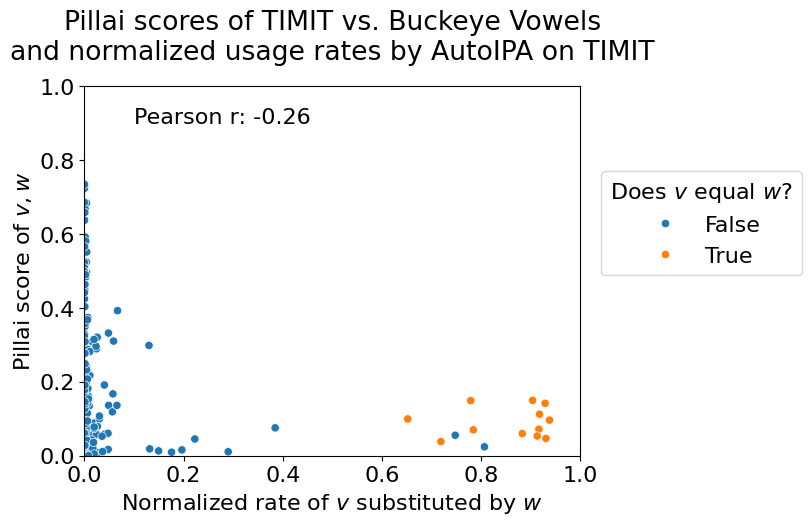

In [25]:
timit_buckeye_pillai_df["same_vowel"] = timit_buckeye_pillai_df["Buckeye_Vowel"] == timit_buckeye_pillai_df["TIMIT_Vowel"]
plot_pillai_substitution_rate_relationship_scatter(timit_buckeye_pillai_df, plot_title="Pillai scores of TIMIT vs. Buckeye Vowels\nand normalized usage rates by AutoIPA on TIMIT", pearsons_position=(0.1, 0.9), nsr_col="usage_rate", xlim=(0,1), ylim=(0,1), equality_hue_col="same_vowel")

/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_52103/2081499157.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


<Figure size 1600x700 with 0 Axes>

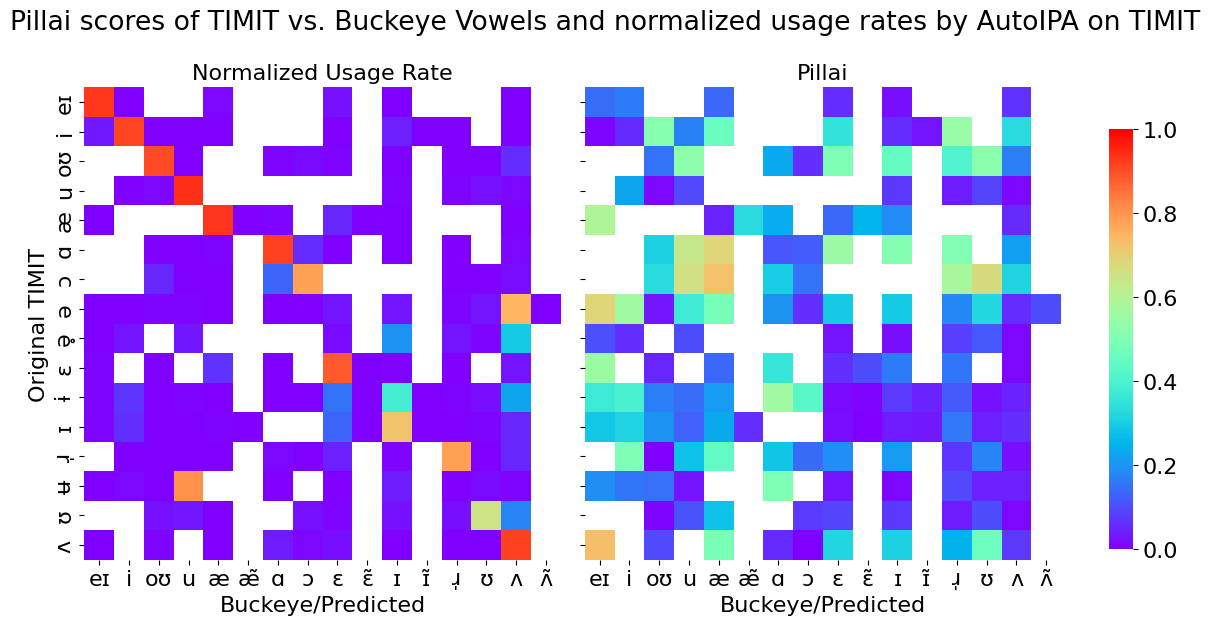

In [26]:
plot_pillai_substitution_rate_relationship_heatmap(
    timit_buckeye_pillai_df,
    "Pillai scores of TIMIT vs. Buckeye Vowels and normalized usage rates by AutoIPA on TIMIT",
    nsr_col="usage_rate",
    nsr_label="Normalized Usage Rate",
    xlabel="Buckeye/Predicted",
    ylabel="Original TIMIT",
    mask_above_diagonal=False
)